Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
target
B    357
M    212
Name: count, dtype: int64
Data Shape: (569, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target                   569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null   

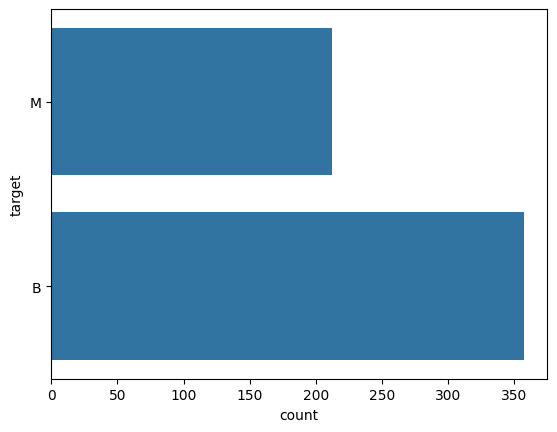

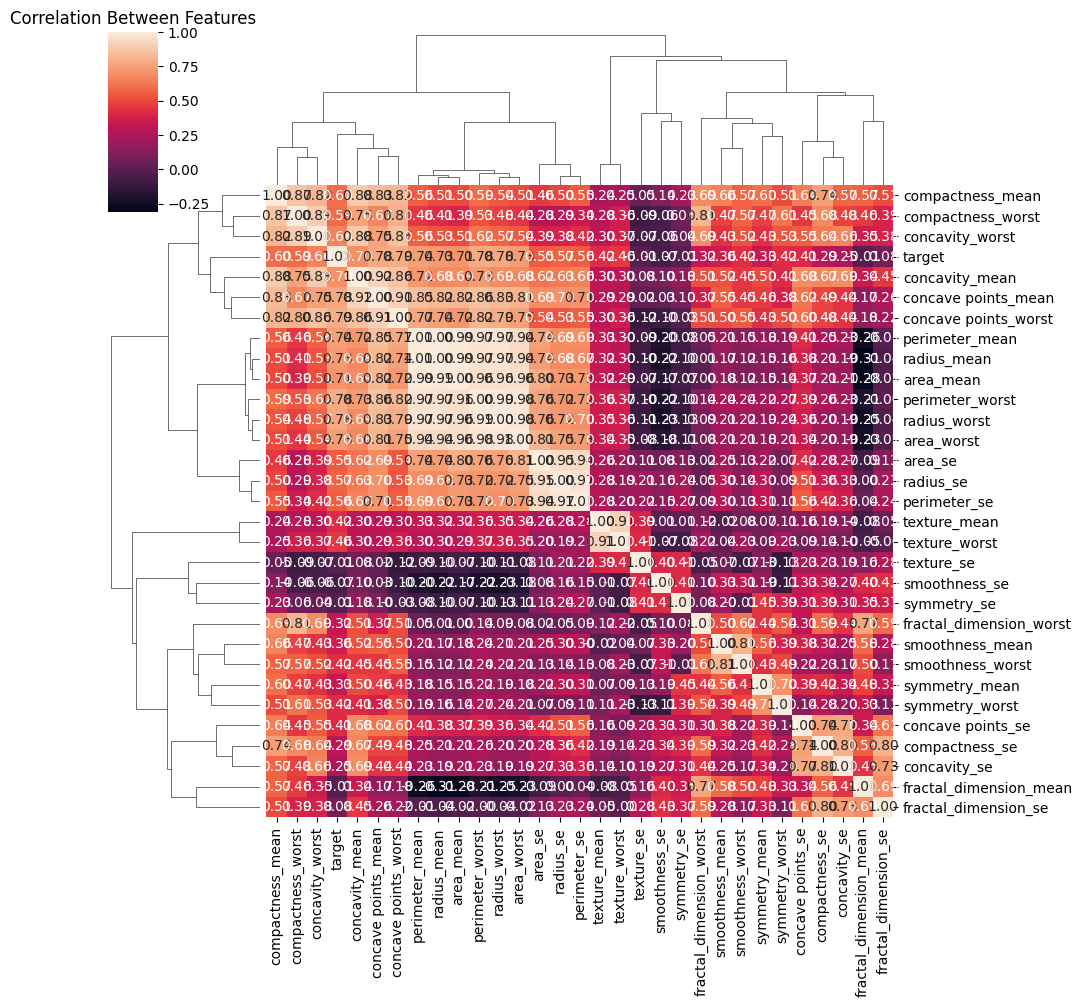

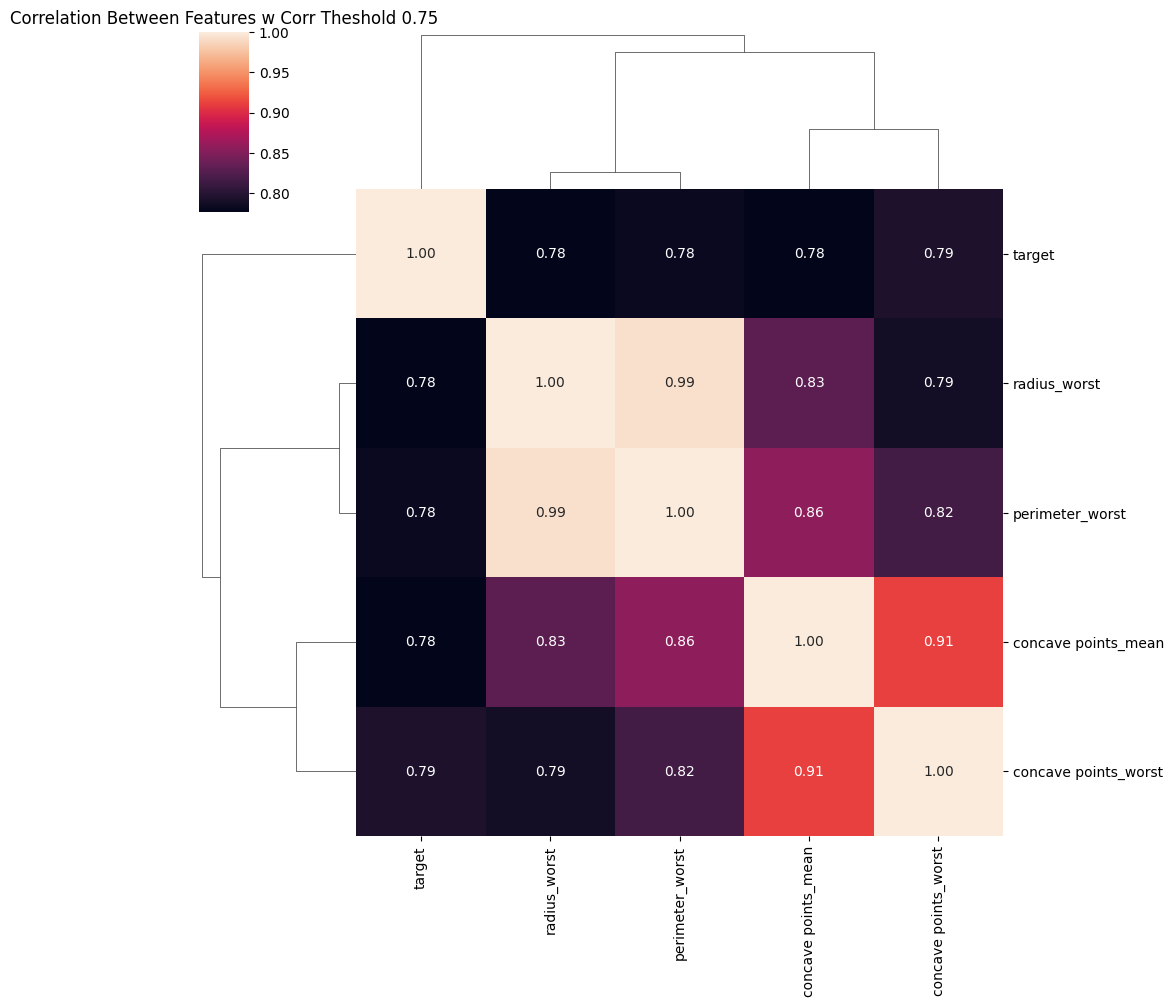

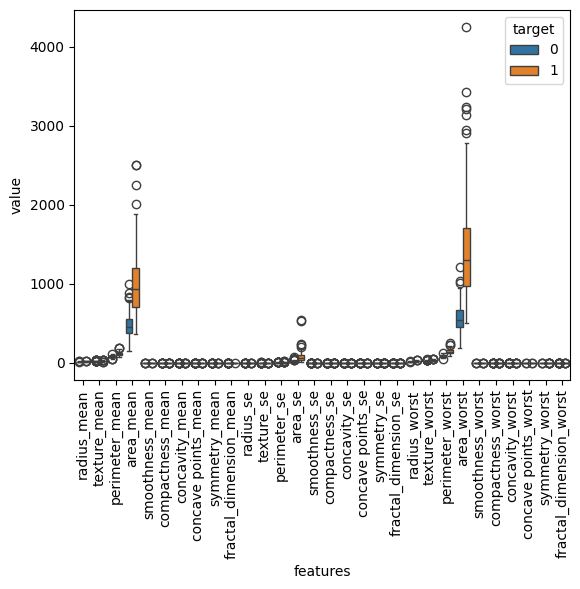

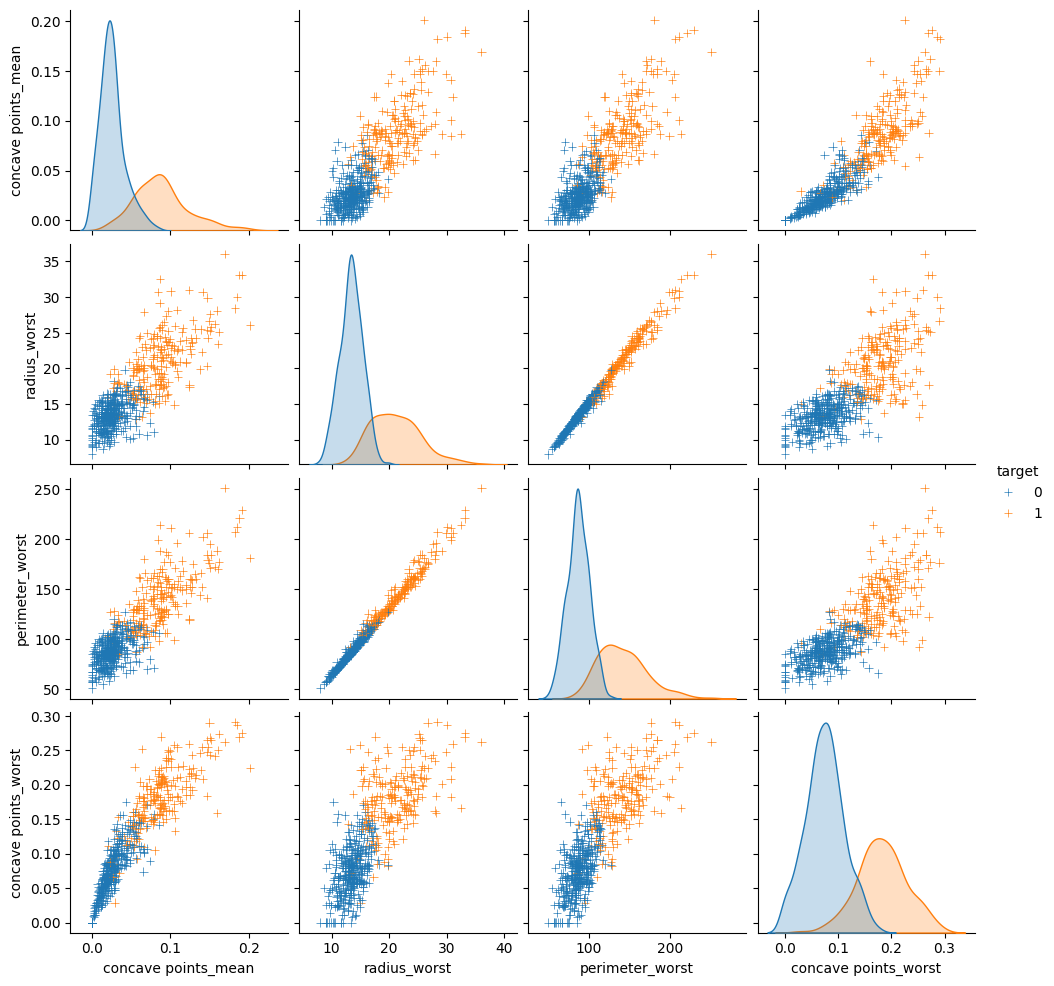

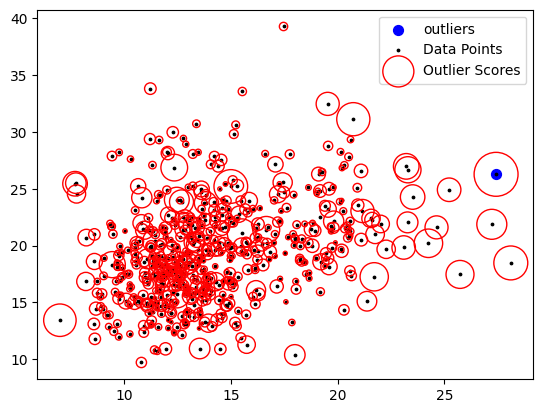

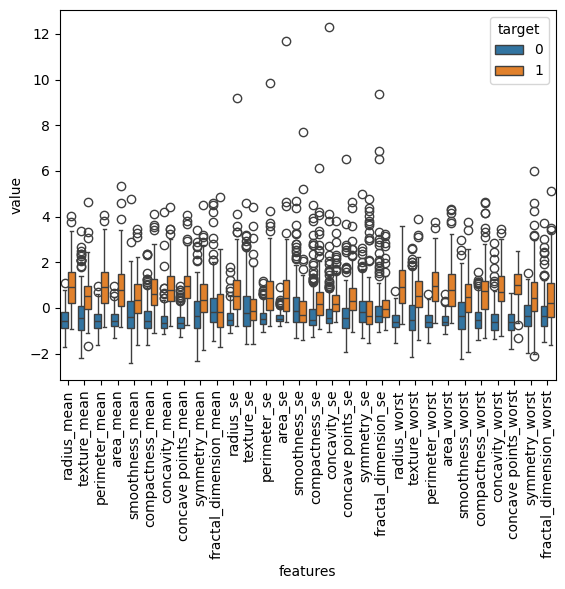

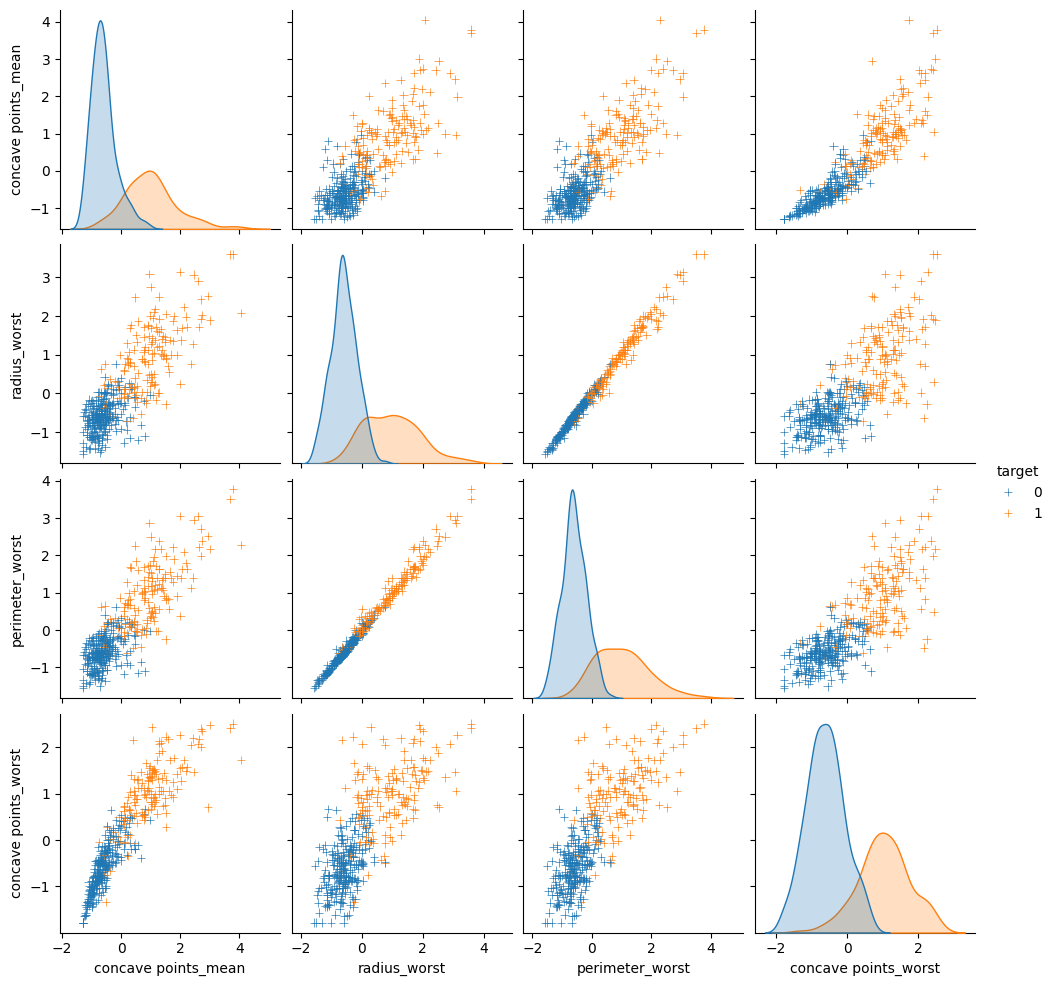

Score :  0.9532163742690059
CM :  [[108   1]
 [  7  55]]
Basic KNN Acc :  0.9532163742690059

Best training score : 0.9670512820512821 with paremeters : {'n_neighbors': 4, 'weights': 'uniform'}

Test Score: 0.9590643274853801, Train Score: 0.9773299748110831

CM Test:  [[107   2]
 [  5  57]]
CM Train:  [[248   0]
 [  9 140]]

Best training score : 0.9419230769230769 with paremeters : {'n_neighbors': 9, 'weights': 'uniform'}

Test Score: 0.9239766081871345, Train Score: 0.947103274559194

CM Test:  [[103   6]
 [  7  55]]
CM Train:  [[241   7]
 [ 14 135]]

Best training score : 0.9873076923076922 with paremeters : {'n_neighbors': 1, 'weights': 'uniform'}

Test Score: 0.9941520467836257, Train Score: 1.0

CM Test:  [[108   1]
 [  0  62]]
CM Train:  [[248   0]
 [  0 149]]


<Axes: xlabel='X_test_nca_p1', ylabel='X_test_nca_p2'>

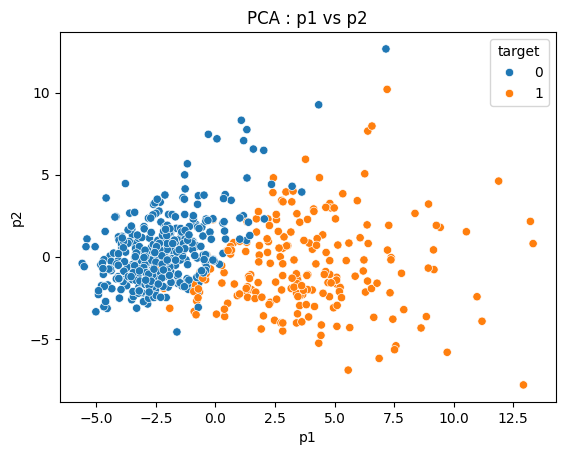

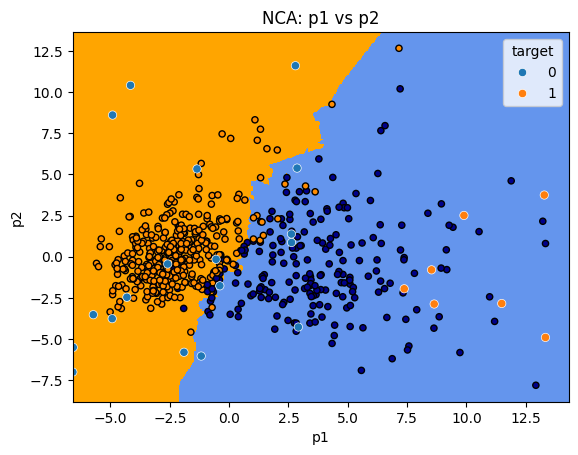

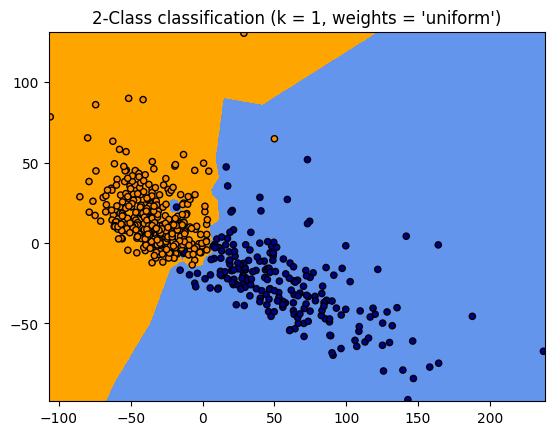

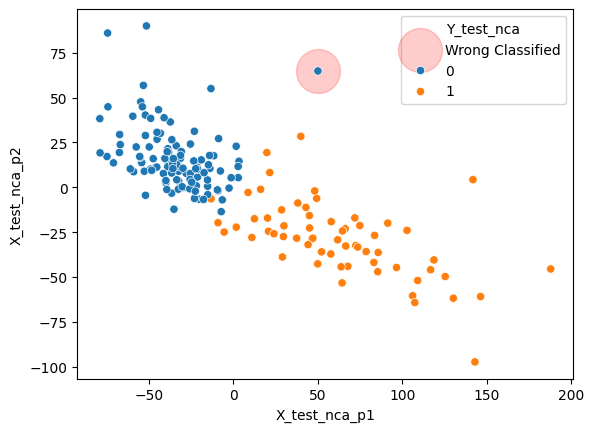

In [ ]:
# -*- coding: utf-8 -*-

"""
 Göğüs Kanseri Sınıflandırma --> Projenin amacı göğüs kanseri tanısı konulan kişilerde, iyi huylu mu - kötü
huylu mu olduğunu tespit etmektedir.
"""

# Kütüphanelerimizi Projemize Dahil Ediyoruz.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler

# GridSearchCV --> KNN best paremetleri bulmak için kullanırız.
from sklearn.model_selection import train_test_split, GridSearchCV

# Başarım Sonucu Değerlendirmek için Kullanırız
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis, LocalOutlierFactor
from sklearn.decomposition import PCA

# Proje Sırasında Hata Olmayan Uyarıları Görmemek için Kullanırız
import warnings
warnings.filterwarnings("ignore")

# Verimizi okuyoruz.
data = pd.read_csv('/cancer.csv')
from google.colab import drive
drive.mount('/content/drive')

# İstemediğimiz Features' ları projemizden çıkartıyoruz. (axis = 1 ' colunun drop edileceğini gösteriyor)
data.drop(['Unnamed: 32','id'], inplace = True, axis = 1)

#  Özelliklerin başlığını değiştiriyoruz
data = data.rename(columns = {"diagnosis":"target"})

# VERİMİZİ İNCELEMEYE BASLIYORUZ

# Kaç İyi Huylu, Kaç Kötü Huylu kanser hücresi olduğuna bakıyoruz.
sns.countplot(data["target"])
print(data.target.value_counts())

# String ifadeleri rakamlara çeviriyoruz çünkü train yaparken gerekli olucak.( Benign(İyi Huylu) = 0 , Malignant(Kötü Huylu) = 1 olarak değiştiriyoruz )
data["target"] = [1 if i.strip() == "M" else 0 for i in data.target]

#  Datamızın boyutunu öğreniyoruz
print("Data Shape:", data.shape)

#  datamızı gözden geçiriyoruz
data.info()

"""
Dataya bakıyoruz standardization gereklimi, eğer veriler arasında büyük farklar varsa standardization gereklidir.
"""
describe = data.describe()

#  Detaylı veri analizimizi gerçekleştiriyoruz.
corr_matrix = data.corr()


#  özellikler arasındaki ilişkiye bakıyoruz.
sns.clustermap(corr_matrix, annot = True, fmt = ".2f")
plt.title("Correlation Between Features")
plt.show()

"""
 ilk olarak sınır değer belirliyoruz. Burada 0.75 olarak belirledik.
Özellikler arasındaki ilişki 0.75 den büyük olanları getiriyoruz.
"""

threshold = 0.75
filtre = np.abs(corr_matrix["target"]) > threshold
corr_features = corr_matrix.columns[filtre].tolist()
sns.clustermap(data[corr_features].corr(), annot = True, fmt = ".2f")
plt.title("Correlation Between Features w Corr Theshold 0.75")
plt.show()

"""
 pd.melt -->  elimizdeki datayı eritmemizi sağlar, yani istediğimiz kolonları tek bir kolonda toplamamıza yarar.
     id_vars--> Hangi kolonları istediğimizi buraya yazarız.
"""
data_melted = pd.melt(data, id_vars = "target",
                      var_name = "features",
                      value_name = "value")

"""
 plt.boxplot --> Bu tür bir grafik, dağıtımın çeyrek değerlerini-aşırı değerler ile birlikte göstermektedir.
"""
plt.figure()
sns.boxplot(x = "features", y = "value", hue = "target", data = data_melted)
plt.xticks(rotation = 90)
plt.show()

"""
sns.pairplot --> Tüm veri çevresi boyunca, sayısal sütünlar için çift yönlü ilişkiler çizer.
"""
sns.pairplot(data[corr_features], diag_kind = "kde", markers = "+", hue = "target")
plt.show()


"""
 veriyi y ve x olmak üzere iki parçaya ayırıyoruz. (y --> Target , x --> target hariç tüm kolonlar )
"""
y = data.target
x = data.drop(["target"], axis = 1)


columns = x.columns.tolist()

"""
 aykırı değerleri tespit etmek için kullanılır.
"""
# outlier -->  Datasetimiz içerisinde diğer verilerden daha farklı aykırı olan veriler.
clf = LocalOutlierFactor()

# outlier mi değilmi diye bakıyoruz -1 ise outlier
y_pred = clf.fit_predict(x)

#  outlier factor değerlere ihtiyacımız var(Buradan outlier olanları daha iyi gözlemleyebiliriz)
X_score = clf.negative_outlier_factor_

# dataframe oluşturup outlier factor değerlerini buraya atıyoruz
outlier_score = pd.DataFrame()
outlier_score["score"] = X_score

#  outlier değeri 2,5 üstü olanları bize göstericek
threshold = -2.5
filtre = outlier_score["score"] < threshold
outlier_index = outlier_score[filtre].index.tolist()


# verinin dağılımına göz atıyoruz
plt.figure()
plt.scatter(x.iloc[outlier_index,0],x.iloc[outlier_index,1],color = "blue", s = 50, label = "outliers")
plt.scatter(x.iloc[:,0],x.iloc[:,1],color = "k", s = 3, label = "Data Points")


# çizdirme işlemi için normalizasyon yapıyoruz
radius = (X_score.max()- X_score) / (X_score.max() - X_score.min())
outlier_score["radius"] = radius

# kanser hücrelerinin çaplarına göz atıyoruz
plt.scatter(x.iloc[:,0],x.iloc[:,1],s = 1000*radius, edgecolors = "r", facecolors = "none", label = "Outlier Scores")
plt.legend()
plt.show()


#  outlier drop ediyoruz
x = x.drop(outlier_index)
y = y.drop(outlier_index).values

# Train test split -->  Test ve eğitim verilerimizi ayırıyoruz
test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = test_size, random_state = 42)

# standrization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train, columns = columns)
X_train_df_describe = X_train_df.describe()
X_train_df["target"] = Y_train

"""
 pd.melt -->  elimizdeki datayı eritmemizi sağlar, yani istediğimiz kolonları tek bir kolonda toplamamıza yarar.
     id_vars--> Hangi kolonları istediğimizi buraya yazarız.
"""
data_melted = pd.melt(X_train_df, id_vars = "target",
                      var_name = "features",
                      value_name = "value")

#  görselleştirerek verimizi inceliyoruz
plt.figure()
sns.boxplot(x = "features", y = "value", hue = "target", data = data_melted)
plt.xticks(rotation = 90)
plt.show()

sns.pairplot(X_train_df[corr_features], diag_kind = "kde", markers = "+",hue = "target")
plt.show()

"""
 Kullanacağımız knn sınıflandırma algoritmasını projemize dahil ediyoruz.
"""

# komşu sayını 2 olarak belirliyoruz ve nesnemizi oluşturuyoruz.
knn = KNeighborsClassifier(n_neighbors = 2)


# Algoritmamızı eğitiyoruz.
knn.fit(X_train, Y_train)


# artık modelimiz hazır olduğuna göre bir tahminde bulunuyoruz.
y_pred = knn.predict(X_test)

# Ne kadar doğru, ne kadar yanlış tahmin de bulunmuşuz buna bakıyoruz.
cm = confusion_matrix(Y_test, y_pred)

# Başarı skorumuza bakıyoruz.
acc = accuracy_score(Y_test, y_pred)
score = knn.score(X_test, Y_test)

print("Score : ", score)
print("CM : ", cm)
print("Basic KNN Acc : ", acc)

#  best paremetreleri belirlememiz lazım. Projemiz için en iyi paremetreleri aşağıdaki fonksiyonu kullanarak tespit ediyoruz.
def KNN_Best_Params(x_train, x_test, y_train, y_test):

    # knn algoritması için denenecek parametreleri yazıyoruz. Bu parametreler arsında en iyi olanı bulacağız.
    k_range = list(range(1,31))
    weight_options = ["uniform","distance"]
    print()
    param_grid = dict(n_neighbors = k_range, weights = weight_options)


    knn = KNeighborsClassifier()

    # GridSearchCV ' yi kullanarak en iyi parametrelerimizi buluyoruz.
    grid = GridSearchCV(knn, param_grid, cv = 10, scoring = "accuracy")
    grid.fit(x_train, y_train)


    # grid.best_score_ --> en iyi skoru verir. grid.best_params_ --> en iyi skoru döndüren parametreleri verir.
    print("Best training score : {} with paremeters : {}".format(grid.best_score_, grid.best_params_))
    print()

    knn = KNeighborsClassifier(**grid.best_params_) # best paremetre olarak gelen değerlerimiz.
    knn.fit(x_train, y_train)

    y_pred_test = knn.predict(x_test)
    y_pred_train = knn.predict(x_train)

    cm_test = confusion_matrix(y_test, y_pred_test)
    cm_train = confusion_matrix(y_train, y_pred_train)

    acc_test = accuracy_score(y_test, y_pred_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    print("Test Score: {}, Train Score: {}".format(acc_test, acc_train))
    print()
    print("CM Test: ",cm_test)
    print("CM Train: ",cm_train)

    return grid


# yazdığımız fonksiyonu çağırarak verilerimizi gönderiyoruz.
grid = KNN_Best_Params(X_train, X_test, Y_train, Y_test)


# PCA
"""
 PCA --> Kısaca açıklamak gerekirse, mümkün olduğa kadar bilgi tutarak verinin boyutunu azaltan yöntem.Belli
başlı özellikleri azaltabiliriz.
"""
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

 #  30 tane olan featurları 2 ye indiriyoruz
pca = PCA(n_components = 2)
pca.fit(x_scaled)
X_reduced_pca = pca.transform(x_scaled)
pca_data = pd.DataFrame(X_reduced_pca, columns = ["p1","p2"])
pca_data["target"] = y


sns.scatterplot(x = "p1", y = "p2", hue = "target", data = pca_data)
plt.title("PCA : p1 vs p2")

# artık yeni bir veri setimiz olduğu için tekrar eğitiyoruz
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(X_reduced_pca, y, test_size = test_size, random_state = 42)

# yazdığımız fonksiyonu çağırarak verilerimizi gönderiyoruz.
grid_pca = KNN_Best_Params(X_train_pca, X_test_pca, Y_train_pca, Y_test_pca)

# Burada görselleştirme işlemi yapıyoruz. 4 tane renk seçiyoruz
cmap_light = ListedColormap(['orange',  'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'darkblue'])

h = .05 # ağdaki adım boyutu
X = X_reduced_pca
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = grid_pca.predict(np.c_[xx.ravel(), yy.ravel()])


# Sonucu bir renk grafiğine yerleştirelim
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Eğitim noktalarını da çizin
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("%i-Class classification (k = %i, weights = '%s')"
          % (len(np.unique(y)),grid_pca.best_estimator_.n_neighbors, grid_pca.best_estimator_.weights))

# NCA
"""
 NCA --> Amacı leave one out sınıflandırma performansını maksimize edecek şekilde input verilerinin doğrusal
dönüşümünü kullanarak mesafe metriğini öğrenmektir.
Leave one out : Belirli bir mesafe ölçüsü kullanarak K en yakın komşunun birlikte başka tek bir noktayı predict
etmeye çalıştığı yöntemdir.
"""

nca = NeighborhoodComponentsAnalysis(n_components = 2, random_state = 42)
nca.fit(x_scaled, y)
X_reduced_nca = nca.transform(x_scaled)
nca_data = pd.DataFrame(X_reduced_nca, columns = ["p1","p2"])
nca_data["target"] = y
sns.scatterplot(x = "p1",  y = "p2", hue = "target", data = nca_data)
plt.title("NCA: p1 vs p2")

X_train_nca, X_test_nca, Y_train_nca, Y_test_nca = train_test_split(X_reduced_nca, y, test_size = test_size, random_state = 42)

grid_nca = KNN_Best_Params(X_train_nca, X_test_nca, Y_train_nca, Y_test_nca)

cmap_light = ListedColormap(['orange',  'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'darkblue'])

h = .2 # ağdaki adım boyutu
X = X_reduced_nca
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = grid_nca.predict(np.c_[xx.ravel(), yy.ravel()])

# Sonucu bir renk grafiğine yerleştirelim
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Eğitim noktalarını da çizin
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("%i-Class classification (k = %i, weights = '%s')"
          % (len(np.unique(y)),grid_nca.best_estimator_.n_neighbors, grid_nca.best_estimator_.weights))

# yaptığımız yanlış sınıflanıdırmları buluyoruz.
knn = KNeighborsClassifier(**grid_nca.best_params_)
knn.fit(X_train_nca,Y_train_nca)
y_pred_nca = knn.predict(X_test_nca)
acc_test_nca = accuracy_score(y_pred_nca,Y_test_nca)
knn.score(X_test_nca,Y_test_nca)


test_data = pd.DataFrame()
test_data["X_test_nca_p1"] = X_test_nca[:,0]
test_data["X_test_nca_p2"] = X_test_nca[:,1]
test_data["y_pred_nca"] = y_pred_nca
test_data["Y_test_nca"] = Y_test_nca

plt.figure()
diff = np.where(y_pred_nca!=Y_test_nca)[0]
plt.scatter(test_data.iloc[diff,0],test_data.iloc[diff,1],label = "Wrong Classified",alpha = 0.2,color = "red",s = 1000)

sns.scatterplot(x="X_test_nca_p1", y="X_test_nca_p2", hue="Y_test_nca",data=test_data)
